In [26]:
from esim.utils import plotting, util
import numpy as np
import esim
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy.optimize import leastsq

In [4]:
def get_scan_results(config_name, scan_name):
    full_config = f'{config_name}_{scan_name}_*/results.npz'
    config_dir = f'{esim.output_dir}/{full_config}'
    res = glob.glob(config_dir)
    return res

In [31]:
def calc_final_temp(E, t, tau, n, plot=True):
    """
    Calculate the final temperature based on average values after n*tau time.
    
    Parameters
    ----------
    E : arr
        Energy/Temperature values
    t : arr
        Time stamps
    tau : float
        Cooling time
    n : int
        The choice of n tau to be considered when calculating temperature
    plot : bool
        Whether to plot the E vs t after n*tau time
        
    Returns
    -------
    E_avg : float
        Average final energy/temperature depending on the unit of input E
    """
    E_sum = [] # split into two sections, below and above T_res
    E_sum2 = []
    t_all = []
    t_2 = []
    for i in range(len(t)):
        if t[i] > n*tau:
            if  E[i] < 0.4:
                E_sum.append(E[i])
                t_all.append(t[i])
            else:
                E_sum2.append(E[i])
                t_2.append(t[i])
                
    E_avg = sum(E_sum+E_sum2)/len(E_sum+E_sum2)
    
    if plot:
        plt.plot(t_all, E_sum, 'b.', markersize=1)
        plt.plot(t_2, E_sum2, 'g.', markersize=1)
        plt.axhline(0.4, color='r', label=r'T$_{res}$')
        plt.axhline(E_avg, color='orange', linestyle='--', label=r'T$_f$' + f' = {E_avg:.2f} K')
        plt.xlabel('t (us)')
        plt.ylabel('T (K)')
        plt.legend()
        plt.grid()
        plt.show()
        
    return E_avg

def boltzmann_fit(E, param):
    """
    Do a boltzmann fit of the energy values E.
    
    Parameters
    ----------
    E : arr
        Energy/temperature values
    param : module
        The module that contains all parameters, used to find constants such as param.kB
    
    Returns
    -------
    c : arr
        List of the output fitting parameters
    """
    #Energy_fitfunc  = lambda p, E: p[0]*1/np.sqrt(np.pi*E*param.kB*p[1])*np.exp(- E/(param.kB * p[1]))
    Energy_fitfunc  = lambda p, E: p[0]*1/np.sqrt(np.pi*E*p[1])*np.exp(- E/(p[1]))
    Energy_errfunc  = lambda p, x, y: (y - Energy_fitfunc(p, x))
    weights = np.ones(len(E))/len(E)
    Energy_n, Energy_bin_edges,_ = plt.hist(E, bins=100, weights=weights, histtype='step', lw=2, align='mid')
    
    # = plt.hist(Energy, 60, density=True, color=‘green’, alpha=0.75)
    xdata = 0.5*(Energy_bin_edges[1:] + Energy_bin_edges[:-1])
    xdata = xdata
    ydata = Energy_n
    init  = [1, 0.5]
    out   = leastsq(Energy_errfunc, init, args=(xdata, ydata))
    c = out[0]
    #print("A exp[-(x-mu)/sigma] + k ")
    #print("Fit Coefficients:")
    #print(c[0],c[1],abs(c[2]),c[3])
    plt.plot(xdata, Energy_fitfunc(c, xdata), '--', label=r'Fit $f(E)=\frac{A}{\sqrt{\pi E \tau}} ~e^{-E/\tau}$' + f', A={c[0]:.2f}, ' + r'$\tau$' + f' ={c[1]:.2f} K')
    #plt.plot(xdata, ydata)
    #plt.title(r'$A = %.3f\  \  \sigma = %.3f\ k = %.3f $' %(c[0],abs(c[1]),c[2]))
    plt.xlabel('Energy (K)')
    plt.ylabel('Probability')
    plt.grid()
    plt.legend()
    plt.show()
    
    return c

In [21]:
# This function takes a configuration name and variable name that was scanned and returns a list of file names
config_name, scan_name = "singleZ_test_noise_10us", "seed_id"
all_results = get_scan_results(config_name, scan_name)
param = util.get_parameters(config_name) # get the python module that contains all parameters
E = lambda v, param: param.m * v**2 / param.kB # function to calculate energy in unit K
tau = param.m * param.deff**2 / param.q**2 / param.resistance * 1e6 # in us
print(f'>>> Cooling time: {tau:.4f} us')

>>> Cooling time: 0.0710 us


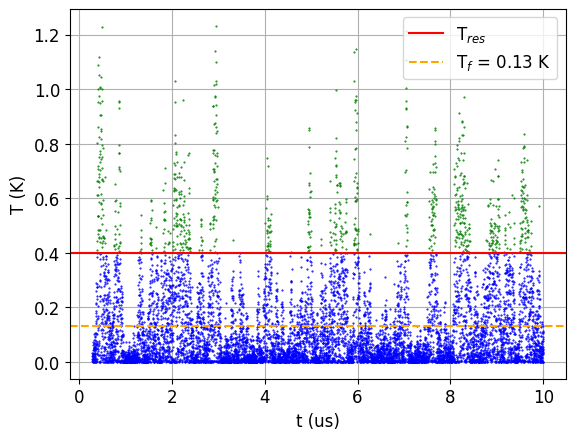

C:\Users\electron\AppData\Local\Temp\ipykernel_30480\566656700.py:68: RuntimeWarning: invalid value encountered in sqrt
  Energy_fitfunc  = lambda p, E: p[0]*1/np.sqrt(np.pi*E*p[1])*np.exp(- E/(p[1]))


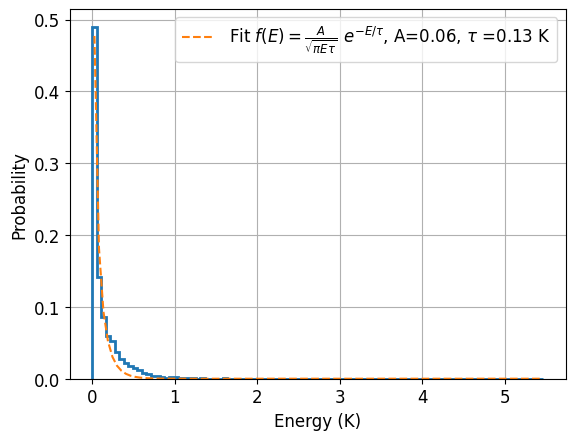

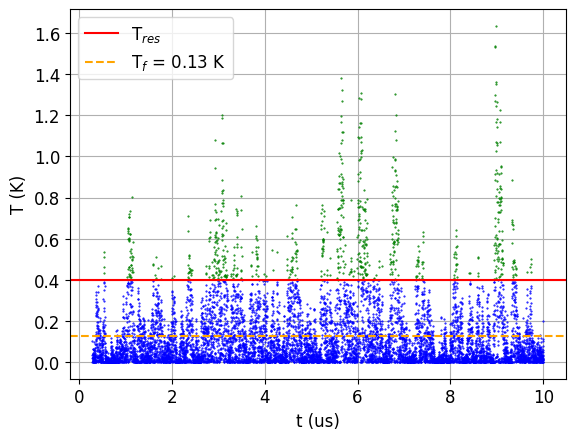

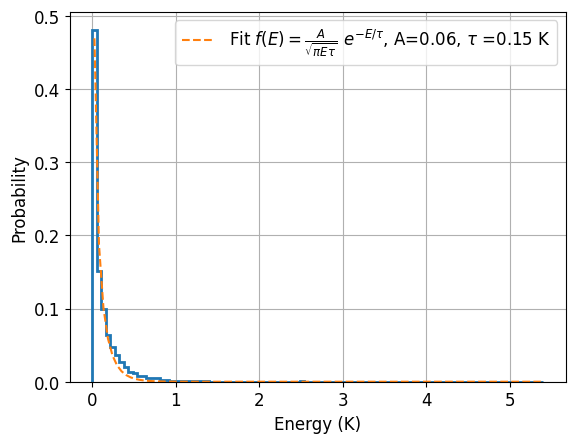

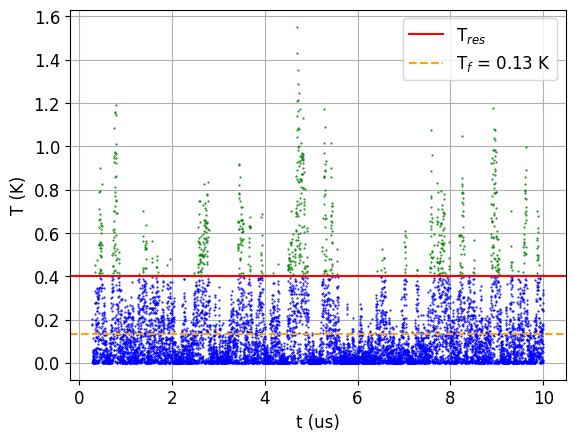

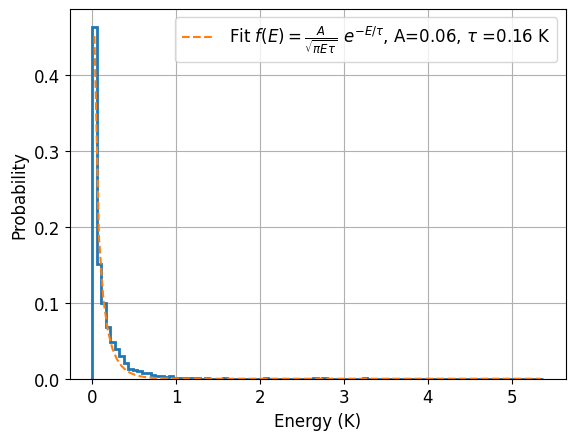

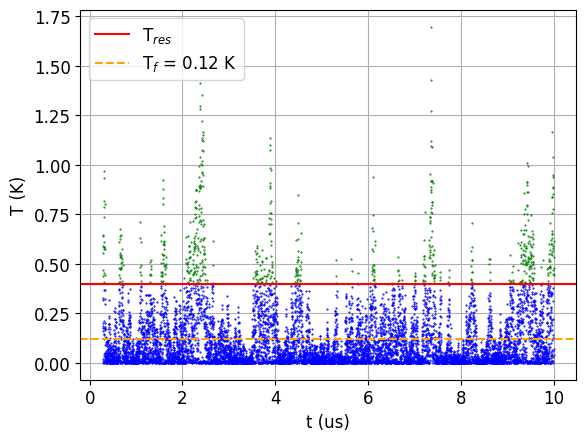

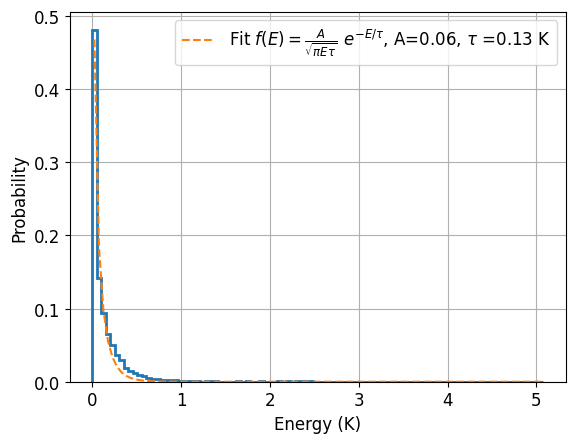

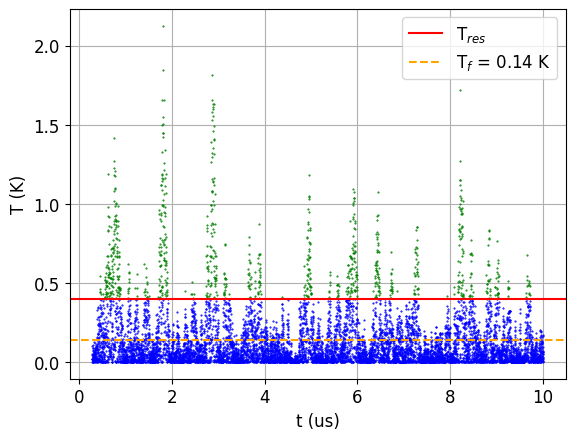

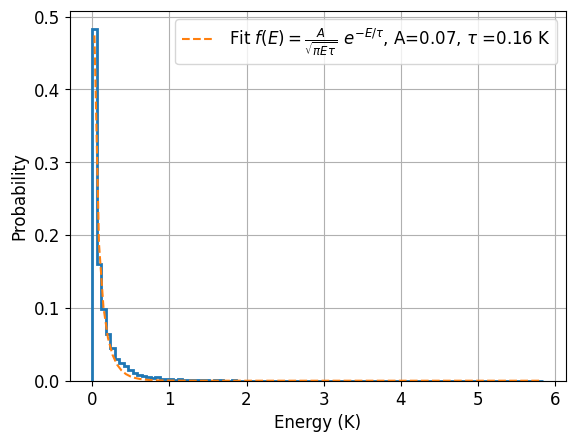

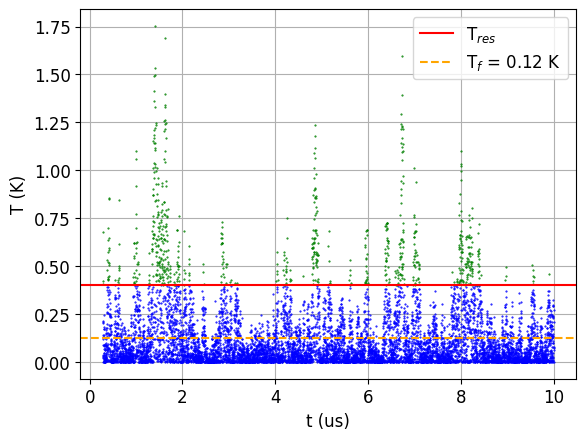

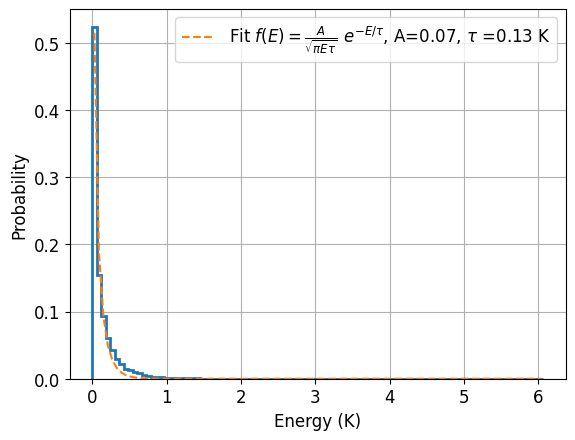

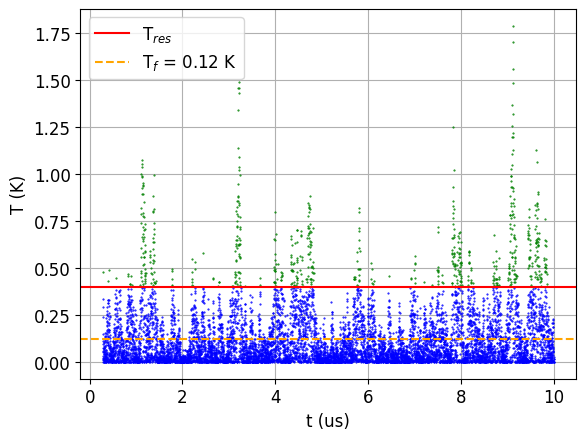

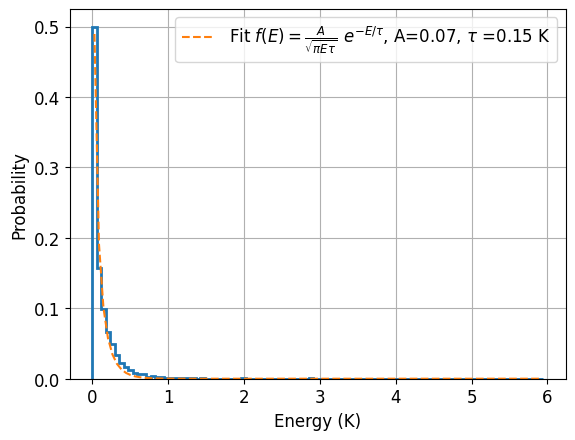

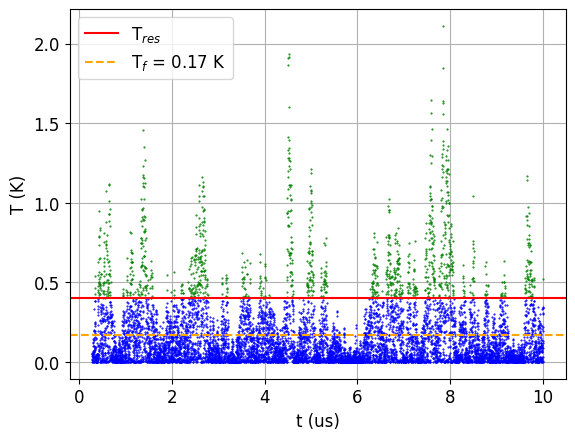

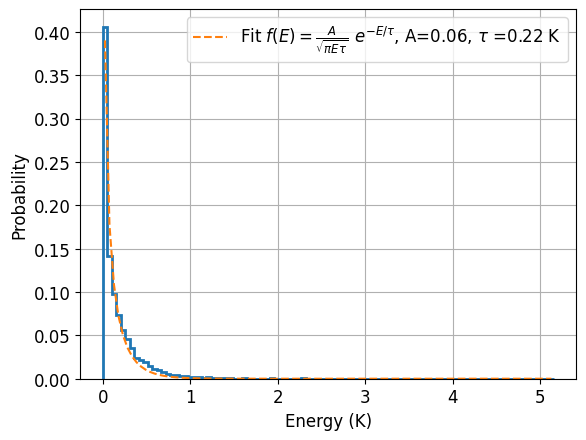

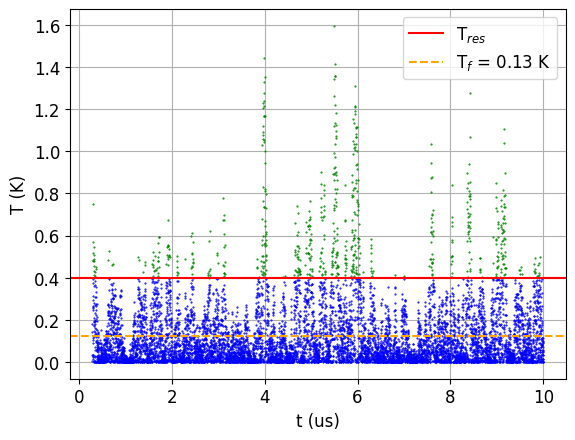

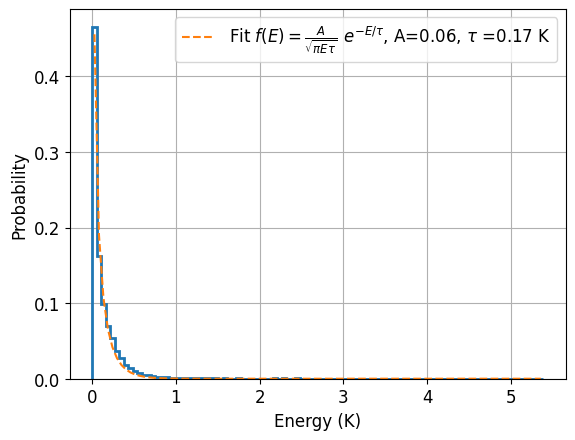

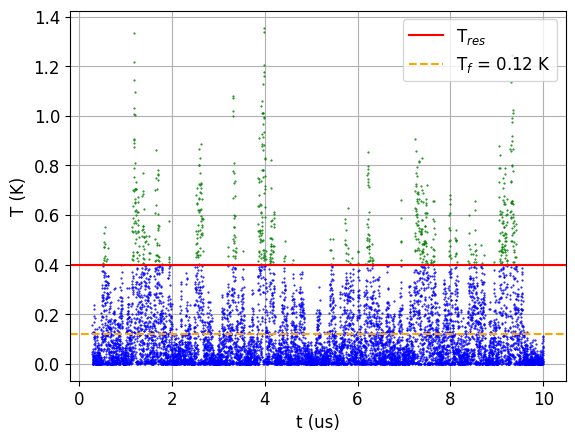

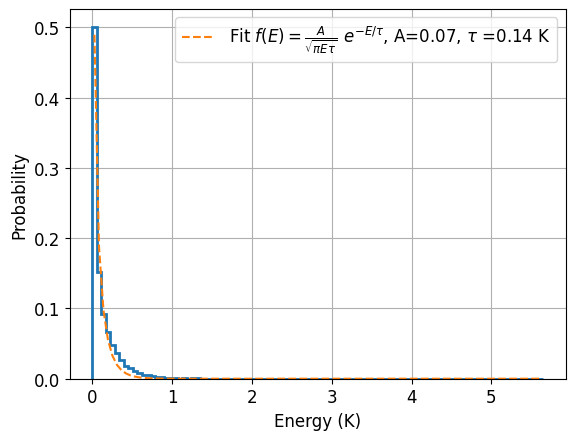

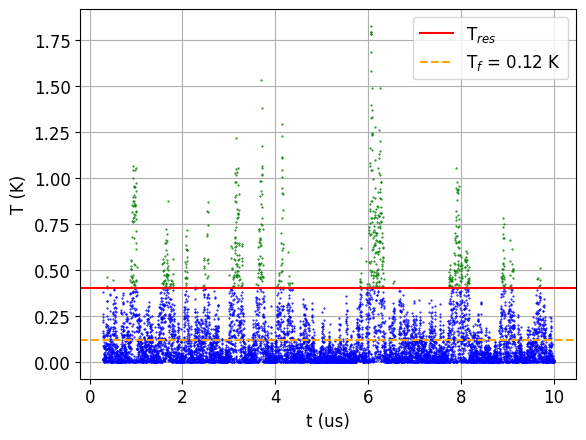

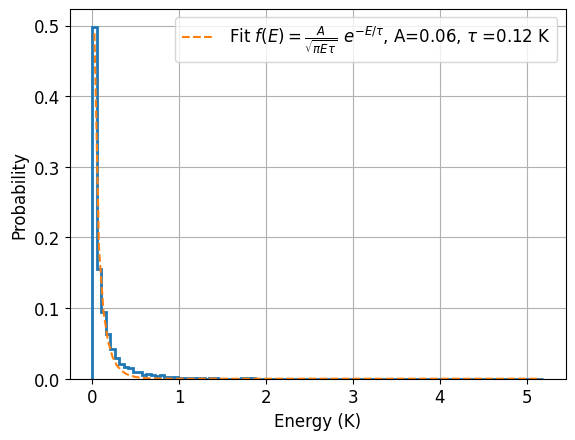

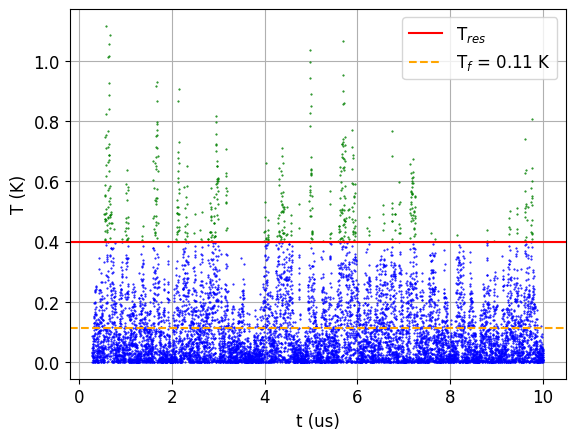

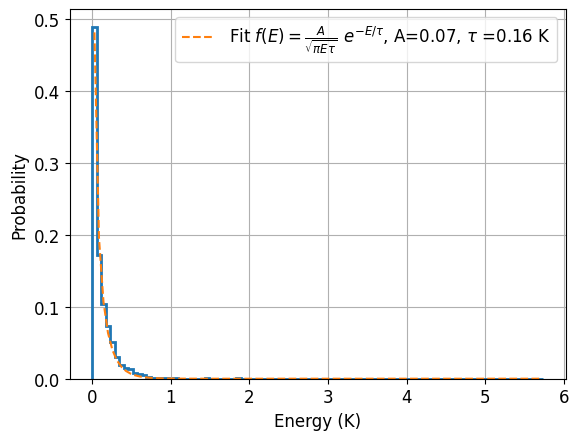

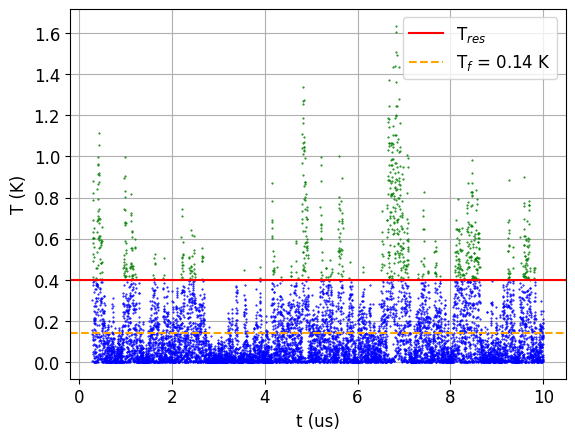

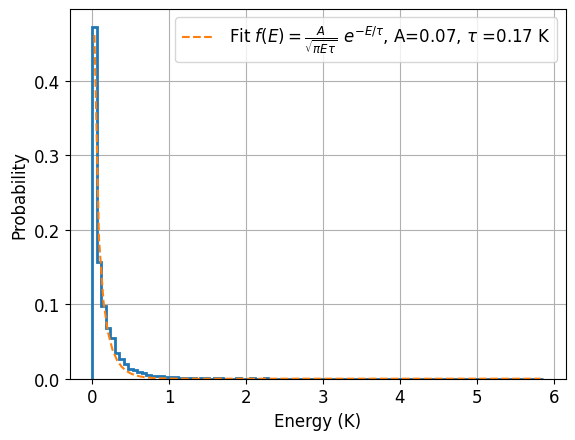

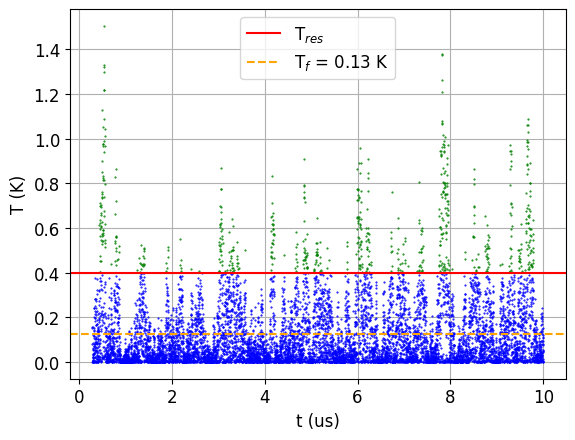

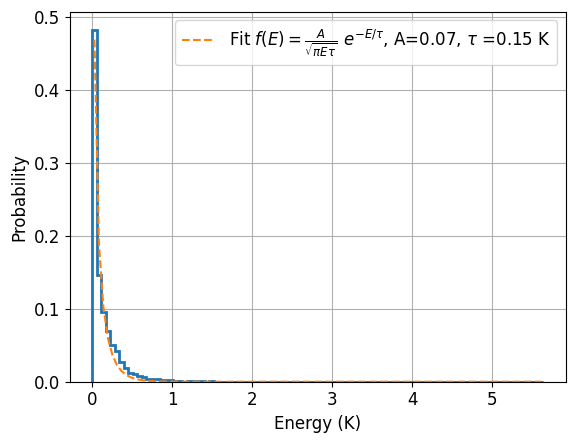

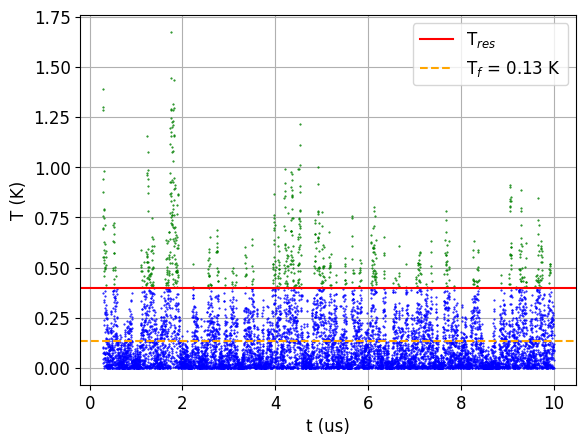

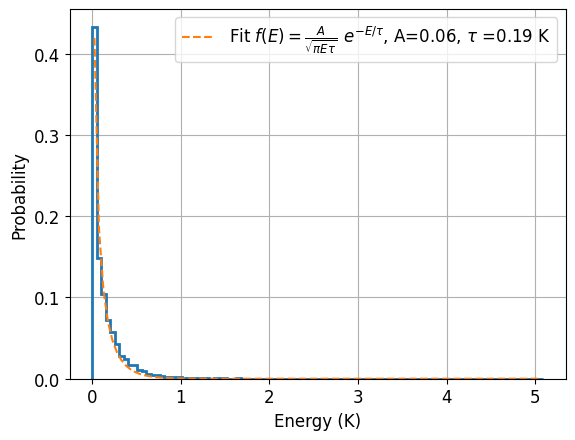

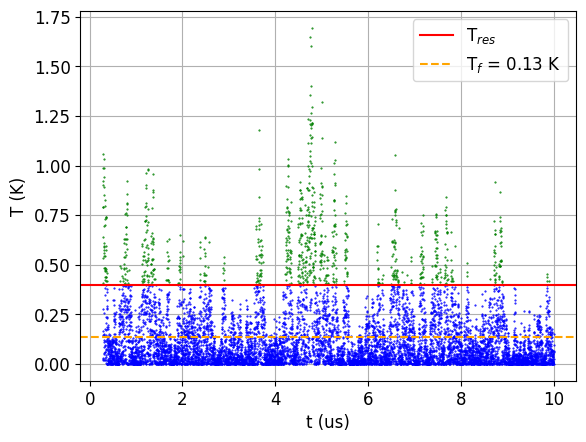

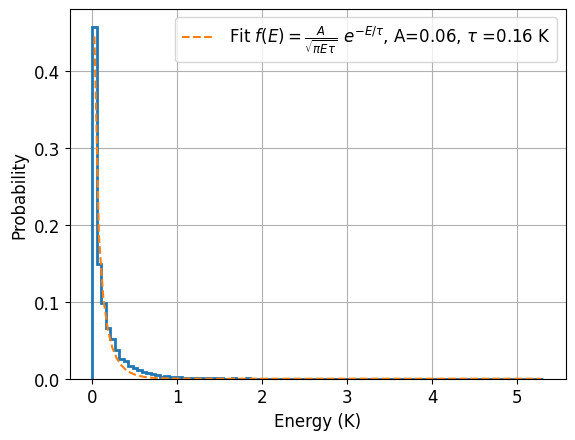

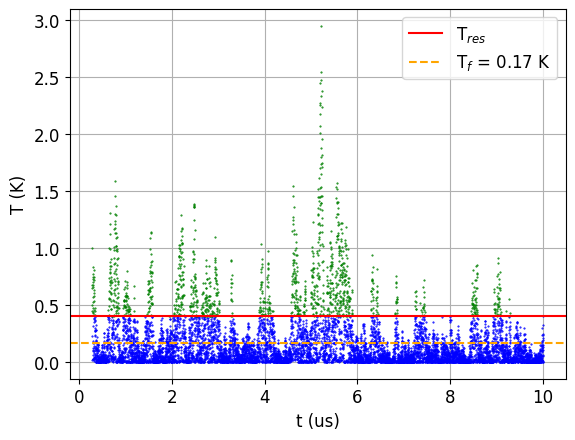

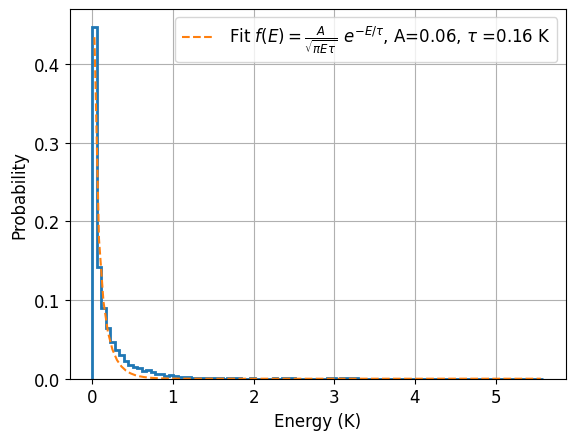

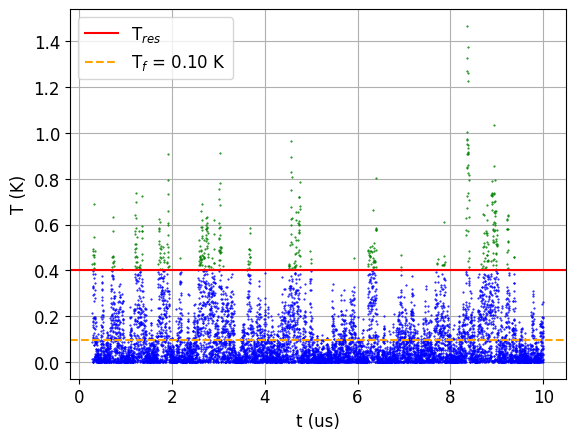

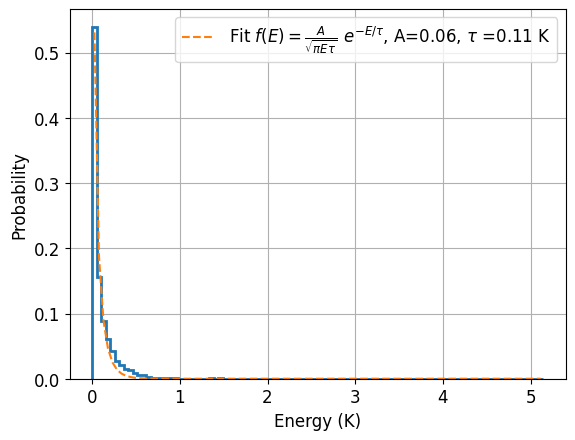

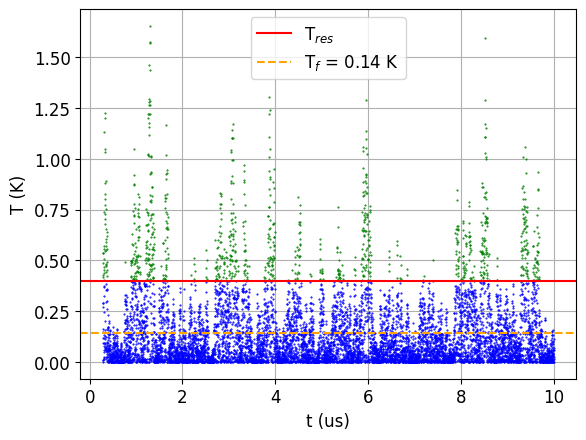

C:\Users\electron\AppData\Local\Temp\ipykernel_30480\566656700.py:68: RuntimeWarning: overflow encountered in exp
  Energy_fitfunc  = lambda p, E: p[0]*1/np.sqrt(np.pi*E*p[1])*np.exp(- E/(p[1]))


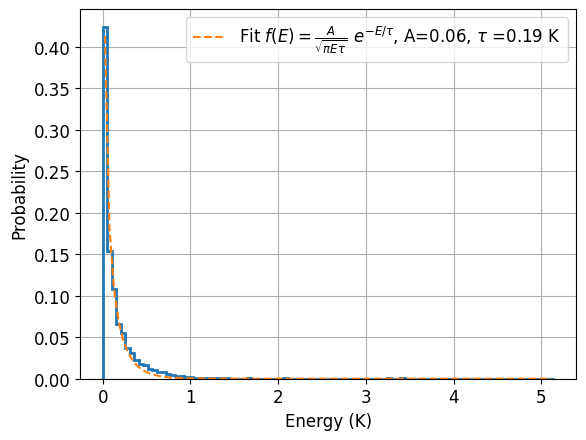

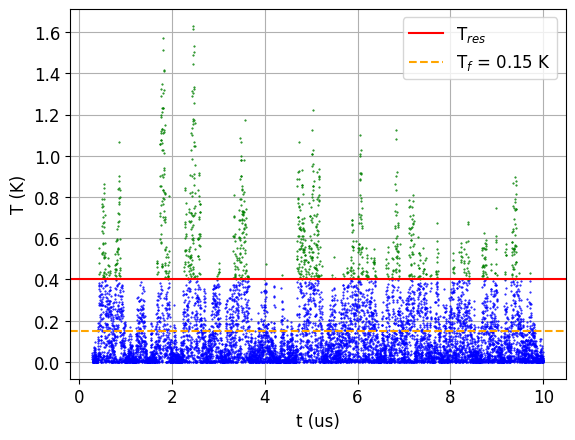

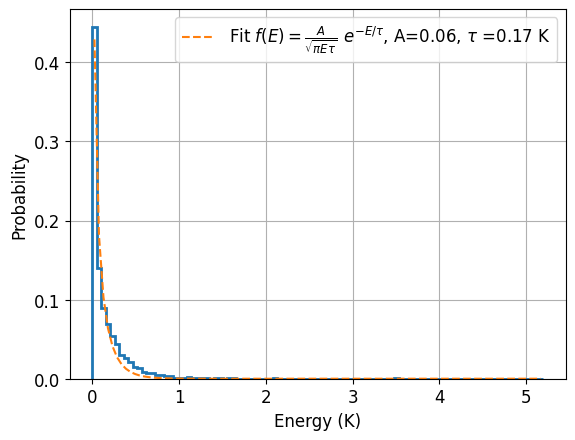

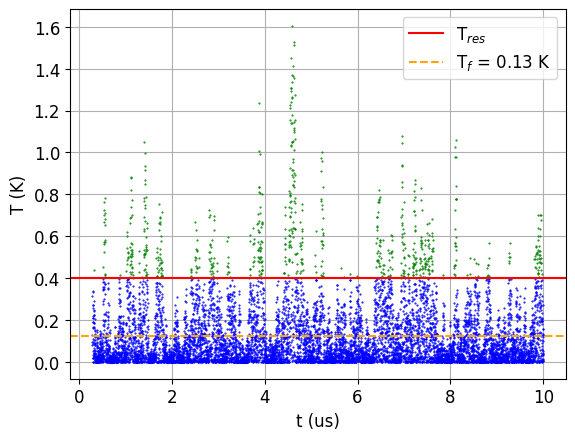

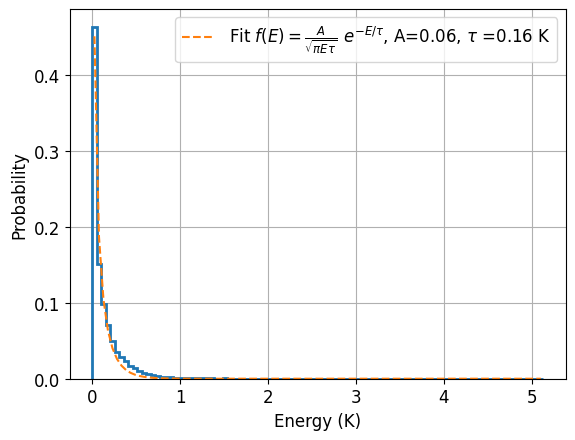

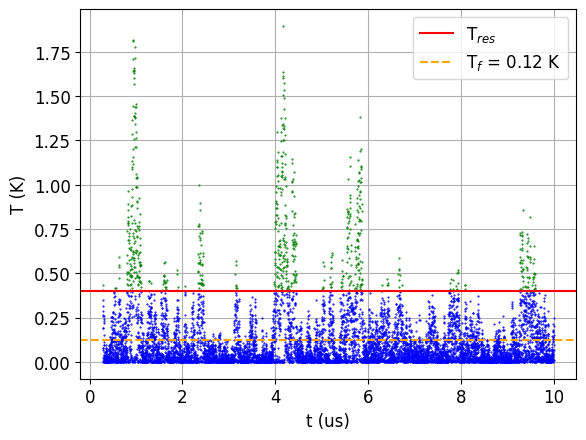

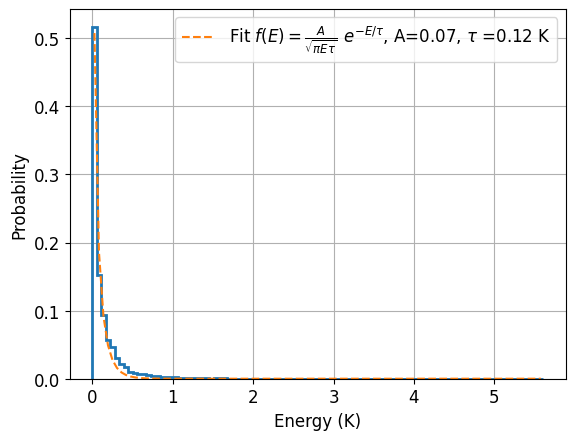

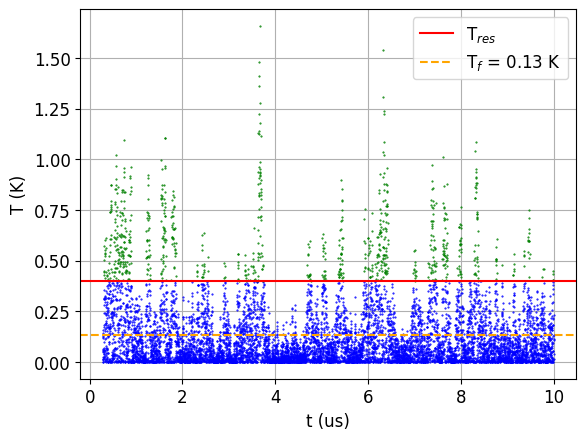

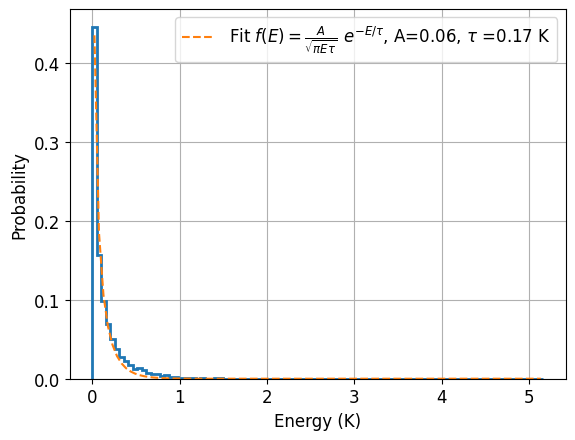

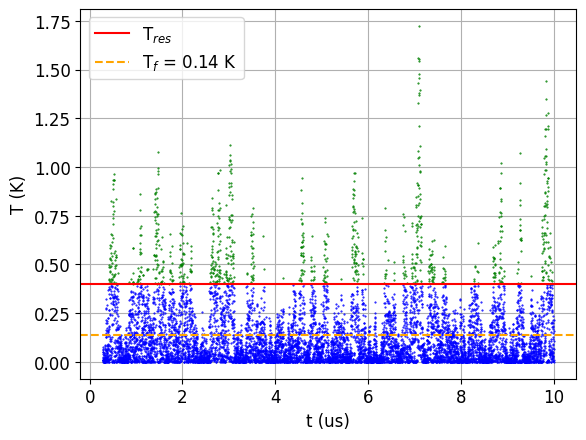

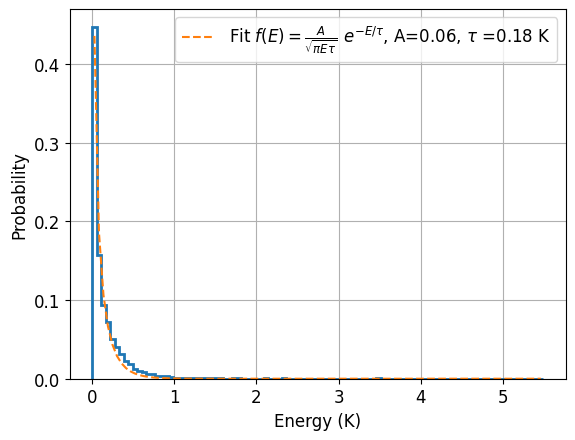

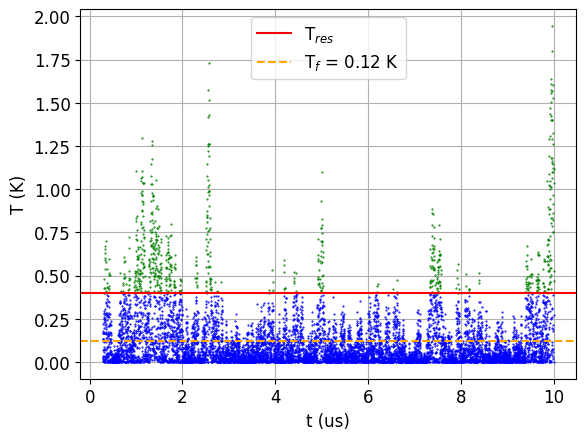

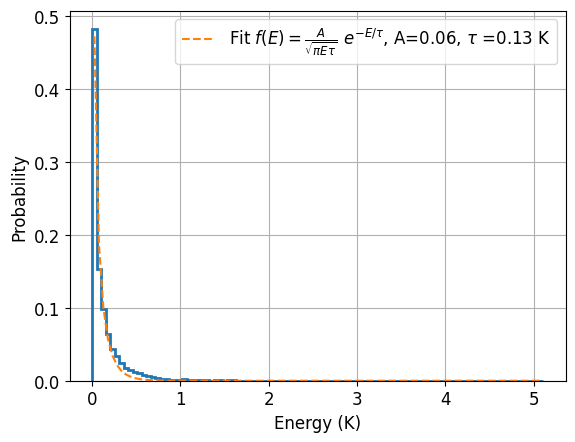

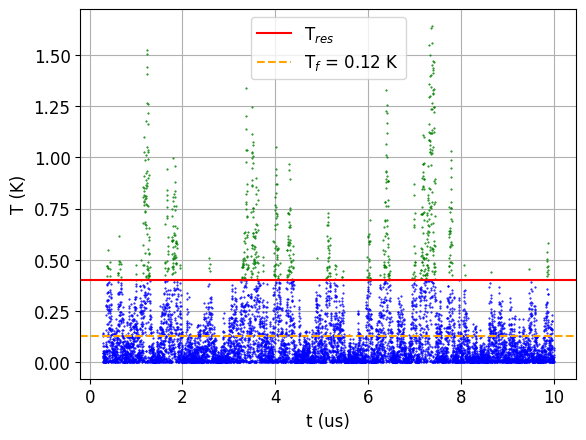

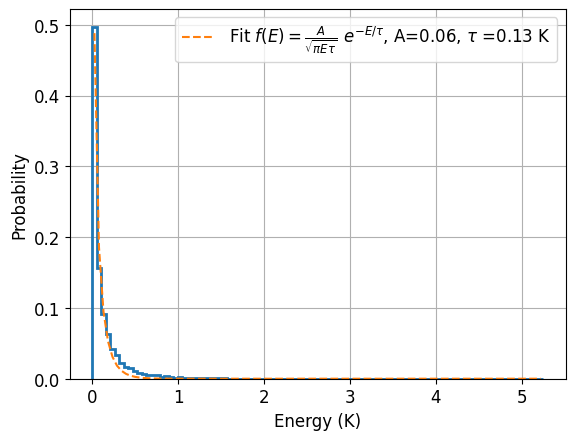

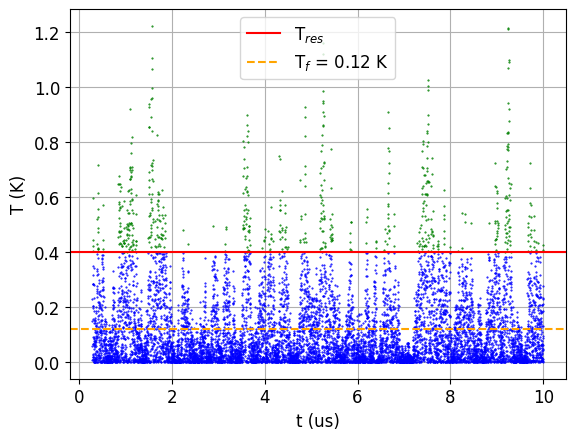

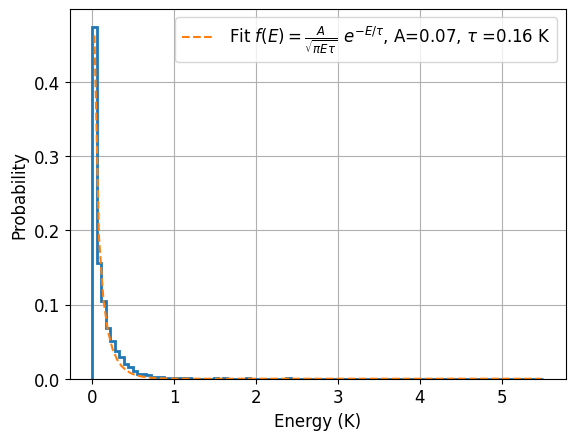

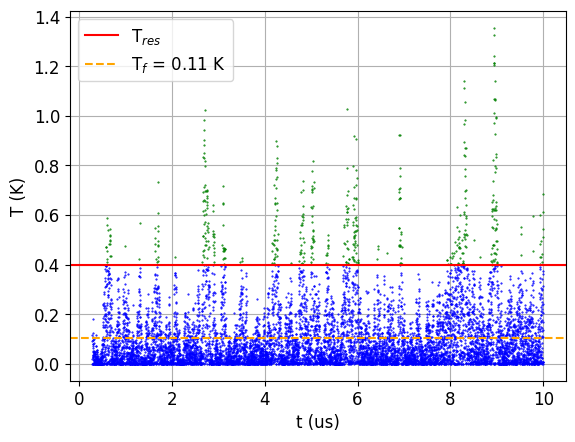

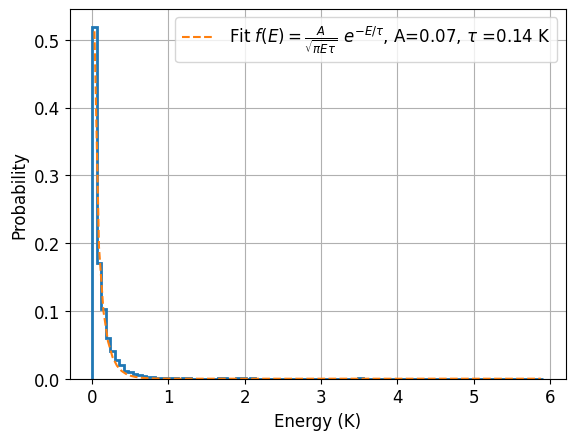

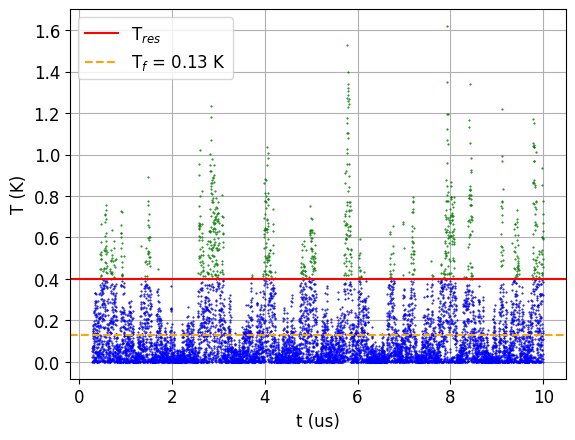

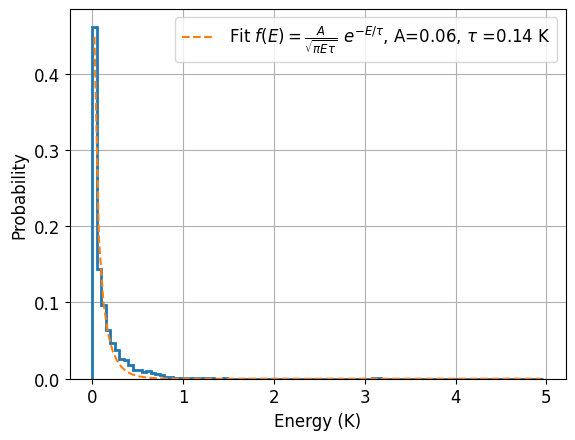

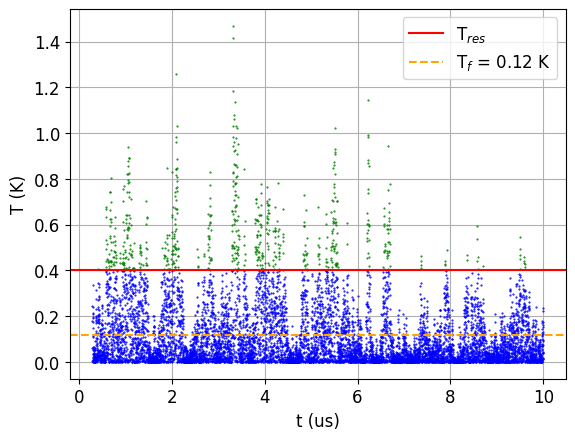

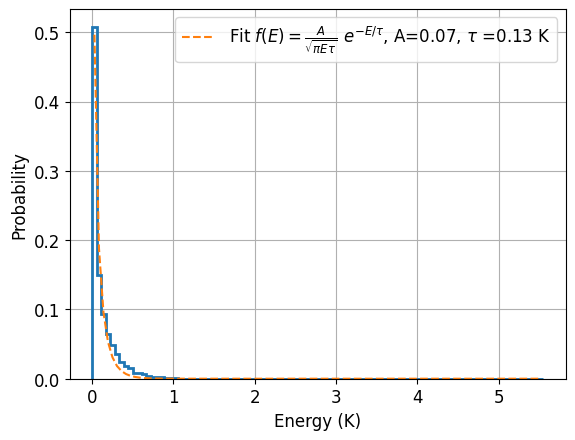

In [32]:
for file_name in all_results:
    result = np.load(file_name)
    z, t = result['z'], result['t'] * 1e6 # t is now in us, originally in s
    vz = result['vz']
    calc_final_temp(E(vz, param), t, tau, n=4, plot=True)
    boltzmann_fit(E(vz,param), param)